STEP 1: Dataset Preparation

In [2]:
import xarray as xr
import numpy as np

# Load cleaned dataset
ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\tasmania_clean_node.nc")

# Features available
feature_vars = ["monthly_rain", "max_temp", "min_temp", "radiation", "spi_1", "spei_1"]

# Extract values into numpy
X_full = np.stack([ds[var].values for var in feature_vars], axis=-1)
# shape: (T, N, F)

# Choose your target
Y_full = ds["spei_1"].values  # shape: (T, N)


In [3]:
L = 6        # input sequence length
lead = 1     # prediction horizon


In [4]:
def create_sequences(X_full, Y_full, L=6, lead=1):
    """
    X_full: (T, N, F)
    Y_full: (T, N)
    L: input sequence length
    lead: prediction horizon
    """
    T, N, F = X_full.shape

    X_list = []
    Y_list = []

    # Iterate over valid windows
    for t in range(L, T - lead):
        x_seq = X_full[t-L:t]           # shape (L, N, F)
        y_target = Y_full[t + lead]     # shape (N,)
        
        X_list.append(x_seq)
        Y_list.append(y_target)

    X_arr = np.stack(X_list)   # (samples, L, N, F)
    Y_arr = np.stack(Y_list)   # (samples, N)

    return X_arr, Y_arr


In [5]:
X_seq, Y_target = create_sequences(X_full, Y_full, L=6, lead=1)

print("X_seq shape:", X_seq.shape)
print("Y_target shape:", Y_target.shape)


X_seq shape: (389, 6, 2951, 6)
Y_target shape: (389, 2951)


In [6]:
import torch

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
Y_tensor = torch.tensor(Y_target, dtype=torch.float32)


STEP 2: Build the Graph Adjacency Matrix (A)

In [8]:
import xarray as xr
import numpy as np

ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\tasmania_clean_node.nc")

mask = ds["valid_mask_flat"].values       # shape (lat*lon)
lat_grid = ds["lat_grid"].values          # (84,92)
lon_grid = ds["lon_grid"].values          # (84,92)


In [10]:
H, W = lat_grid.shape                # 84, 92
N = mask.sum()

# Index map initialized with -1 for oceans
index_map = -1 * np.ones(mask.shape[0], dtype=int)

# Assign each land pixel a node index
index_map[mask] = np.arange(N)

# reshape back to 2D for easier neighbor lookup
index_map_2d = index_map.reshape(H, W)


In [11]:
A = np.zeros((N, N), dtype=np.float32)

for i in range(H):
    for j in range(W):
        node = index_map_2d[i, j]
        if node == -1:
            continue   # skip ocean
        
        # up
        if i > 0 and index_map_2d[i-1, j] != -1:
            A[node, index_map_2d[i-1, j]] = 1
        
        # down
        if i < H-1 and index_map_2d[i+1, j] != -1:
            A[node, index_map_2d[i+1, j]] = 1
        
        # left
        if j > 0 and index_map_2d[i, j-1] != -1:
            A[node, index_map_2d[i, j-1]] = 1
        
        # right
        if j < W-1 and index_map_2d[i, j+1] != -1:
            A[node, index_map_2d[i, j+1]] = 1


In [12]:
# Add self-loops
A_tilde = A + np.eye(N)

# Degree matrix
D = np.sum(A_tilde, axis=1)

# Avoid division by zero
D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-8))

A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt


In [14]:
np.save("Data\GAN_Data\A_norm.npy", A_norm)
print("Saved A_norm.npy with shape:", A_norm.shape)


Saved A_norm.npy with shape: (2951, 2951)


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_35452\3220935700.py:1: SyntaxWarning: invalid escape sequence '\G'
  np.save("Data\GAN_Data\A_norm.npy", A_norm)


STEP 3: Build the Spatio-Temporal Encoder

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

A_norm = torch.tensor(np.load("Data\GAN_Data\A_norm.npy"), dtype=torch.float32)


<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_35452\3253423905.py:6: SyntaxWarning: invalid escape sequence '\G'
  A_norm = torch.tensor(np.load("Data\GAN_Data\A_norm.npy"), dtype=torch.float32)


In [16]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A_norm):
        # X: [batch, nodes, in_dim]
        # A_norm: [nodes, nodes]
        out = torch.einsum("ij,bjk->bik", A_norm, X)   # graph propagation
        out = out @ self.weight                       # linear transform
        return F.relu(out)


In [24]:
class TemporalEncoder(nn.Module):
    def __init__(self, node_hidden, rnn_hidden):
        super().__init__()
        self.gru = nn.GRU(
            input_size=node_hidden,
            hidden_size=rnn_hidden,
            batch_first=True
        )

    def forward(self, H_seq):
        # H_seq: [B, L, N, H]
        B, L, N, H = H_seq.shape

        # Reshape for GRU: combine B and N
        H_seq = H_seq.permute(0, 2, 1, 3)     # [B, N, L, H]
        H_seq = H_seq.reshape(B * N, L, H)    # [B*N, L, H]

        # Run GRU
        _, h_last = self.gru(H_seq)           # h_last: [1, B*N, rnn_hidden]

        h_last = h_last.squeeze(0)            # [B*N, rnn_hidden]

        # Reshape back to [B, N, rnn_hidden]
        h_last = h_last.reshape(B, N, -1)

        return h_last


In [25]:
class LatentEncoder(nn.Module):
    def __init__(self, rnn_hidden, latent_dim):
        super().__init__()
        self.fc_mean = nn.Linear(rnn_hidden, latent_dim)
        self.fc_logvar = nn.Linear(rnn_hidden, latent_dim)

    def forward(self, h_context):
        z_mean = self.fc_mean(h_context)
        z_logvar = self.fc_logvar(h_context)
        return z_mean, z_logvar


In [29]:
class SpatioTemporalEncoder(nn.Module):
    def __init__(self, in_dim, gnn_hidden, rnn_hidden, latent_dim):
        super().__init__()
        
        self.gcn = GCNLayer(in_dim, gnn_hidden)
        self.temporal_encoder = TemporalEncoder(gnn_hidden, rnn_hidden)
        self.latent_encoder = LatentEncoder(rnn_hidden, latent_dim)

    def forward(self, X_seq, A_norm):
        B, L, N, F = X_seq.shape

        # --- Spatial GCN per timestep ---
        H_seq = []
        for t in range(L):
            H_t = self.gcn(X_seq[:, t], A_norm)   # [B, N, gnn_hidden]
            H_seq.append(H_t)

        H_seq = torch.stack(H_seq, dim=1)         # [B, L, N, gnn_hidden]

        # --- Temporal Encoder (per-node GRU) ---
        h_node = self.temporal_encoder(H_seq)     # [B, N, rnn_hidden]

        # --- Global context (mean pool over nodes) ---
        h_context = h_node.mean(dim=1)            # [B, rnn_hidden]

        # --- Latent parameters ---
        z_mean, z_logvar = self.latent_encoder(h_context)   # [B, latent_dim]

        return z_mean, z_logvar



In [30]:
encoder = SpatioTemporalEncoder(
    in_dim=6,            # 6 climate features
    gnn_hidden=32,       # graph hidden size
    rnn_hidden=64,       # temporal encoder
    latent_dim=16        # latent bottleneck
)


In [31]:
X_batch = torch.randn(8, 6, 2951, 6)
z_mean, z_logvar = encoder(X_batch, A_norm)

print(z_mean.shape)      # should be [8, latent_dim]
print(z_logvar.shape)    # should be [8, latent_dim]


torch.Size([8, 16])
torch.Size([8, 16])


STEP 4: Build the Decoder

In [32]:
class LatentToNode(nn.Module):
    def __init__(self, latent_dim, node_hidden, num_nodes):
        super().__init__()
        self.num_nodes = num_nodes
        self.fc = nn.Linear(latent_dim, num_nodes * node_hidden)

    def forward(self, z):
        B = z.size(0)
        x = self.fc(z)                        # [B, num_nodes * node_hidden]
        x = x.view(B, self.num_nodes, -1)     # [B, num_nodes, node_hidden]
        return x


In [33]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A_norm):
        out = torch.einsum("ij,bjk->bik", A_norm, X)   # propagate
        out = out @ self.weight                        # linear
        return torch.relu(out)


In [34]:
class OutputHeads(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc_mean = nn.Linear(hidden_dim, 1)
        self.fc_logstd = nn.Linear(hidden_dim, 1)

    def forward(self, H):
        # H: [B, N, hidden_dim]
        mean = self.fc_mean(H).squeeze(-1)          # [B, N]
        logstd = self.fc_logstd(H).squeeze(-1)      # [B, N]
        std = torch.exp(logstd) + 1e-6              # make positive
        return mean, std


In [35]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, gnn_hidden, num_nodes):
        super().__init__()
        self.latent_to_node = LatentToNode(latent_dim, gnn_hidden, num_nodes)
        self.gcn1 = GCNLayer(gnn_hidden, gnn_hidden)
        self.gcn2 = GCNLayer(gnn_hidden, gnn_hidden)
        self.output_heads = OutputHeads(gnn_hidden)

    def forward(self, z, A_norm):
        # Expand latent vector to node embeddings
        H = self.latent_to_node(z)             # [B, N, H]

        # Graph decoding
        H = self.gcn1(H, A_norm)               # first spatial smooth
        H = self.gcn2(H, A_norm)               # second spatial smooth

        # Predict mean + variance
        mean, std = self.output_heads(H)

        return mean, std                        # both [B, N]


In [36]:
latent_dim = 16
gnn_hidden = 32
num_nodes = 2951

decoder = Decoder(latent_dim, gnn_hidden, num_nodes)

# fake latent input
z = torch.randn(8, latent_dim)

mean, std = decoder(z, A_norm)

print(mean.shape)   # [8, 2951]
print(std.shape)    # [8, 2951]


torch.Size([8, 2951])
torch.Size([8, 2951])


STEP 5: Build the full Conditional Variational Autoencoder (cVAE)

In [37]:
def reparameterize(z_mean, z_logvar):
    std = torch.exp(0.5 * z_logvar)
    eps = torch.randn_like(std)
    return z_mean + eps * std


In [38]:
def gaussian_nll(y_true, mean, std):
    return 0.5 * torch.log(2 * torch.pi * std**2) + ((y_true - mean)**2) / (2 * std**2)


In [39]:
def nll_loss(y_true, mean, std):
    return gaussian_nll(y_true, mean, std).mean()


In [40]:
def kl_loss(z_mean, z_logvar):
    return -0.5 * torch.mean(1 + z_logvar - z_mean.pow(2) - torch.exp(z_logvar))


In [41]:
class CVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X_seq, A_norm, y_true=None):
        # ---- Encoding ----
        z_mean, z_logvar = self.encoder(X_seq, A_norm)

        # ---- Sampling ----
        z = reparameterize(z_mean, z_logvar)

        # ---- Decoding ----
        mean, std = self.decoder(z, A_norm)   # [B, N], [B, N]

        # ---- Training mode ----
        if y_true is not None:
            # likelihood
            nll = nll_loss(y_true, mean, std)
            kl = kl_loss(z_mean, z_logvar)
            return mean, std, nll, kl
        
        # ---- Inference mode ----
        return mean, std


In [42]:
latent_dim = 16
gnn_hidden = 32
rnn_hidden = 64
num_nodes = 2951
in_dim = 6   # your feature count

encoder = SpatioTemporalEncoder(
    in_dim=in_dim,
    gnn_hidden=gnn_hidden,
    rnn_hidden=rnn_hidden,
    latent_dim=latent_dim
)

decoder = Decoder(
    latent_dim=latent_dim,
    gnn_hidden=gnn_hidden,
    num_nodes=num_nodes
)

model = CVAE(encoder, decoder)


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_step(X_batch, Y_batch, A_norm):
    optimizer.zero_grad()

    mean, std, nll, kl = model(X_batch, A_norm, y_true=Y_batch)

    # Total loss (standard VAE)
    loss = nll + 0.1 * kl

    loss.backward()
    optimizer.step()

    return loss.item(), nll.item(), kl.item()


In [44]:
with torch.no_grad():
    mean, std = model(X_batch, A_norm)


In [45]:
samples = mean + std * torch.randn_like(std)


In [46]:
from torch.utils.data import Dataset, DataLoader

class DroughtDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [47]:
train_size = int(0.8 * len(X_seq))
val_size = len(X_seq) - train_size

X_train, X_val = X_seq[:train_size], X_seq[train_size:]
Y_train, Y_val = Y_target[:train_size], Y_target[train_size:]

train_ds = DroughtDataset(X_train, Y_train)
val_ds   = DroughtDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


In [48]:
def train_step(model, X_batch, Y_batch, A_norm, optimizer):
    model.train()
    optimizer.zero_grad()

    mean, std, nll, kl = model(X_batch, A_norm, y_true=Y_batch)
    loss = nll + 0.1 * kl

    loss.backward()
    optimizer.step()

    return loss.item(), nll.item(), kl.item()


In [49]:
def val_step(model, X_batch, Y_batch, A_norm):
    model.eval()
    with torch.no_grad():
        mean, std, nll, kl = model(X_batch, A_norm, y_true=Y_batch)
        loss = nll + 0.1 * kl
    return loss.item(), nll.item(), kl.item()


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

for epoch in range(num_epochs):
    train_losses = []
    val_losses = []

    for Xb, Yb in train_loader:
        Xb = Xb.float()
        Yb = Yb.float()
        t_loss, t_nll, t_kl = train_step(model, Xb, Yb, A_norm, optimizer)
        train_losses.append(t_loss)

    for Xb, Yb in val_loader:
        Xb = Xb.float()
        Yb = Yb.float()
        v_loss, v_nll, v_kl = val_step(model, Xb, Yb, A_norm)
        val_losses.append(v_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {np.mean(train_losses):.4f} | "
          f"Val Loss: {np.mean(val_losses):.4f}")


Epoch 1/50 | Train Loss: 1.4260 | Val Loss: 1.3723
Epoch 2/50 | Train Loss: 1.4154 | Val Loss: 1.3709
Epoch 3/50 | Train Loss: 1.4130 | Val Loss: 1.3707
Epoch 4/50 | Train Loss: 1.4131 | Val Loss: 1.3729
Epoch 5/50 | Train Loss: 1.4102 | Val Loss: 1.3755
Epoch 6/50 | Train Loss: 1.4113 | Val Loss: 1.3711
Epoch 7/50 | Train Loss: 1.4122 | Val Loss: 1.3709
Epoch 8/50 | Train Loss: 1.4142 | Val Loss: 1.3705
Epoch 9/50 | Train Loss: 1.4111 | Val Loss: 1.3725
Epoch 10/50 | Train Loss: 1.4110 | Val Loss: 1.3710
Epoch 11/50 | Train Loss: 1.4108 | Val Loss: 1.3711
Epoch 12/50 | Train Loss: 1.4118 | Val Loss: 1.3704
Epoch 13/50 | Train Loss: 1.4112 | Val Loss: 1.3704
Epoch 14/50 | Train Loss: 1.4122 | Val Loss: 1.3731
Epoch 15/50 | Train Loss: 1.4087 | Val Loss: 1.3725
Epoch 16/50 | Train Loss: 1.4120 | Val Loss: 1.3693
Epoch 17/50 | Train Loss: 1.4098 | Val Loss: 1.3721
Epoch 18/50 | Train Loss: 1.4127 | Val Loss: 1.3741
Epoch 19/50 | Train Loss: 1.4102 | Val Loss: 1.3749
Epoch 20/50 | Train L

In [51]:
import torch.distributions as D

def brier_score(y_true, mean, std, threshold=-1.0):
    # Convert to drought event indicator
    y_event = (y_true < threshold).float()
    
    # predicted probability using normal CDF
    dist = D.Normal(mean, std)
    p_event = dist.cdf(torch.tensor(threshold))

    return torch.mean((p_event - y_event)**2)


In [52]:
def crps_gaussian(y, mean, std):
    # Closed form CRPS for Gaussian
    z = (y - mean) / std
    return std * (z * (2 * torch.distributions.Normal(0,1).cdf(z) - 1) +
                  2 * torch.exp(-0.5 * z**2) / np.sqrt(2*np.pi) - 1/np.sqrt(np.pi))
    
def crps_metric(y_true, mean, std):
    return torch.mean(crps_gaussian(y_true, mean, std))


In [53]:
def reliability_data(y_true, mean, std, threshold=-1.0, bins=10):
    dist = D.Normal(mean, std)
    p = dist.cdf(torch.tensor(threshold))

    # flatten all nodes
    p = p.flatten()
    y = (y_true.flatten() < threshold).float()

    bins_edges = torch.linspace(0, 1, bins+1)
    bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2

    obs_freq = []
    pred_prob = []

    for i in range(bins):
        mask = (p >= bins_edges[i]) & (p < bins_edges[i+1])
        if mask.sum() > 0:
            obs_freq.append(y[mask].mean().item())
            pred_prob.append(bin_centers[i].item())

    return pred_prob, obs_freq


In [54]:
def hit_miss_stats(y_true, mean, std, threshold=-1.0):
    dist = D.Normal(mean, std)
    p = dist.cdf(torch.tensor(threshold))
    
    pred_event = (p > 0.5).float()    # threshold for event probability
    obs_event  = (y_true < threshold).float()
    
    hits = ((pred_event == 1) & (obs_event == 1)).sum().item()
    misses = ((pred_event == 0) & (obs_event == 1)).sum().item()
    false_alarms = ((pred_event == 1) & (obs_event == 0)).sum().item()
    correct = ((pred_event == 0) & (obs_event == 0)).sum().item()

    return hits, misses, false_alarms, correct


STEP 7: Generate & Visualize Probabilistic Drought Maps

In [55]:
torch.save(model.state_dict(), "Data\GAN_Data\cvae_drought_model.pth")


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_35452\2628928678.py:1: SyntaxWarning: invalid escape sequence '\G'
  torch.save(model.state_dict(), "Data\GAN_Data\cvae_drought_model.pth")


In [56]:
model.load_state_dict(torch.load("Data\GAN_Data\cvae_drought_model.pth"))
model.eval()


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_35452\2806628975.py:1: SyntaxWarning: invalid escape sequence '\G'
  model.load_state_dict(torch.load("Data\GAN_Data\cvae_drought_model.pth"))


CVAE(
  (encoder): SpatioTemporalEncoder(
    (gcn): GCNLayer()
    (temporal_encoder): TemporalEncoder(
      (gru): GRU(32, 64, batch_first=True)
    )
    (latent_encoder): LatentEncoder(
      (fc_mean): Linear(in_features=64, out_features=16, bias=True)
      (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (latent_to_node): LatentToNode(
      (fc): Linear(in_features=16, out_features=94432, bias=True)
    )
    (gcn1): GCNLayer()
    (gcn2): GCNLayer()
    (output_heads): OutputHeads(
      (fc_mean): Linear(in_features=32, out_features=1, bias=True)
      (fc_logstd): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [57]:
X_test = torch.tensor(X_val[-1:], dtype=torch.float32)  # shape [1, L, N, F]


In [58]:
with torch.no_grad():
    mean_pred, std_pred = model(X_test, A_norm)


In [59]:
mean_pred = mean_pred.squeeze().numpy()  # [N]
std_pred  = std_pred.squeeze().numpy()


In [60]:
import torch.distributions as D

dist = D.Normal(torch.tensor(mean_pred), torch.tensor(std_pred))
prob_drought = dist.cdf(torch.tensor(-1.0)).numpy()   # [N]


In [61]:
mask = ds["valid_mask_flat"].values        # (lat*lon,)
lat_grid = ds["lat_grid"].values           # (H, W)
lon_grid = ds["lon_grid"].values           # (H, W)

H, W = lat_grid.shape

def to_full_map(node_values):
    full = np.full(mask.shape, np.nan)     # full pixel count
    full[mask] = node_values
    return full.reshape(H, W)


In [63]:
full_mean = to_full_map(mean_pred)
full_std = to_full_map(std_pred)
full_prob = to_full_map(prob_drought)


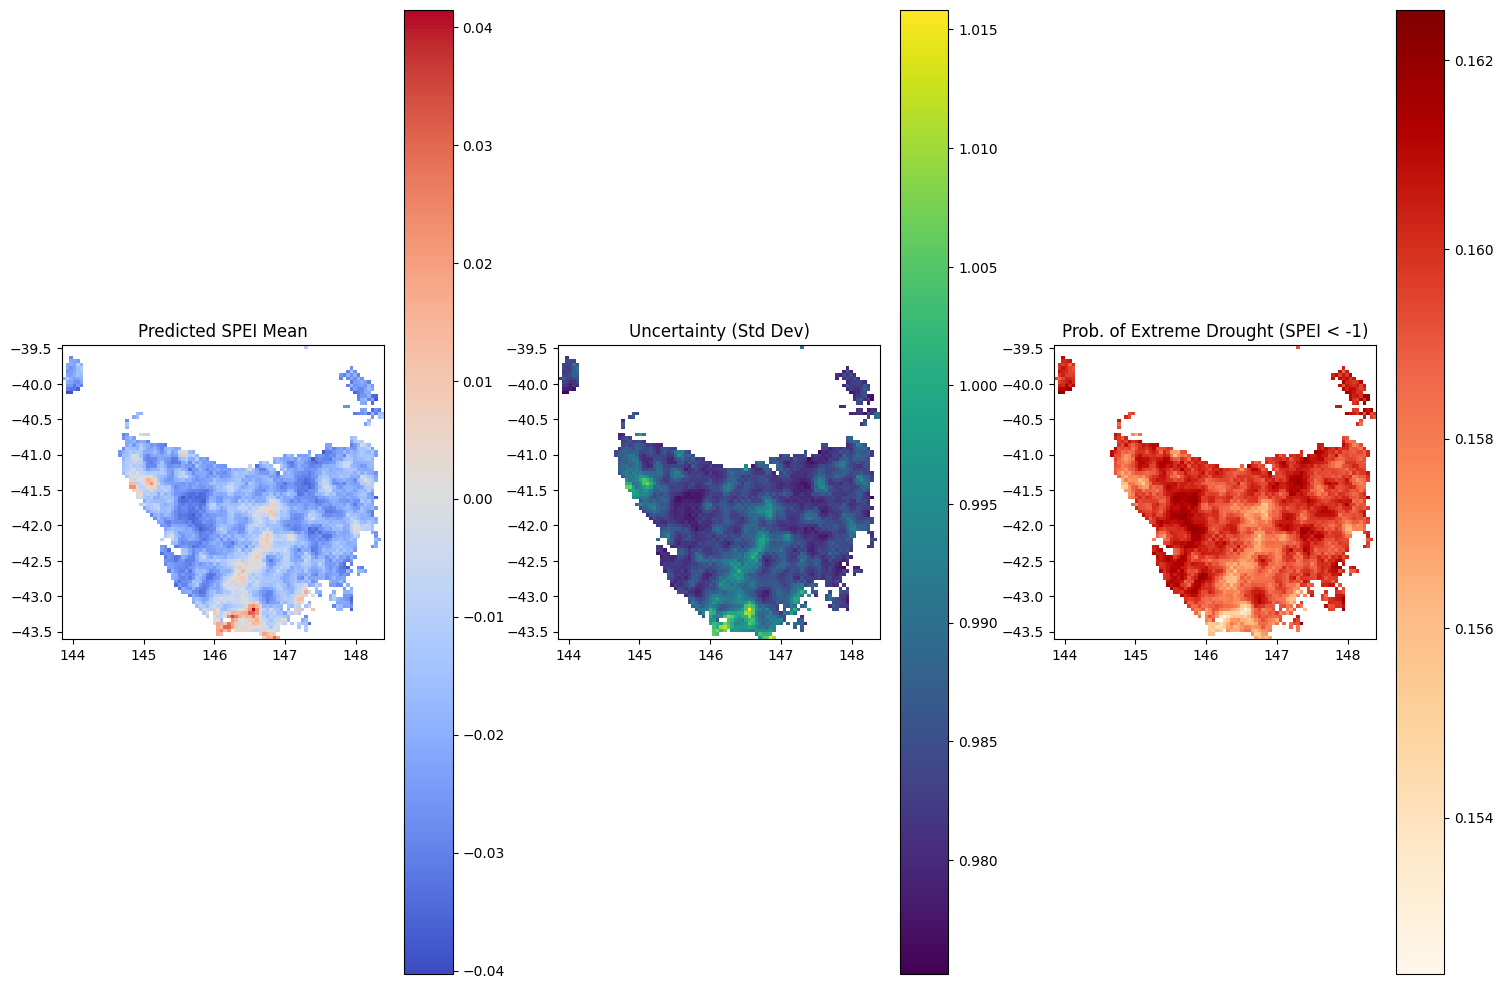

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(full_mean, origin="lower", cmap="coolwarm",
           extent=[lon_grid.min(), lon_grid.max(),
                   lat_grid.min(), lat_grid.max()])
plt.title("Predicted SPEI Mean")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(full_std, origin="lower", cmap="viridis",
           extent=[lon_grid.min(), lon_grid.max(),
                   lat_grid.min(), lat_grid.max()])
plt.title("Uncertainty (Std Dev)")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(full_prob, origin="lower", cmap="OrRd",
           extent=[lon_grid.min(), lon_grid.max(),
                   lat_grid.min(), lat_grid.max()])
plt.title("Prob. of Extreme Drought (SPEI < -1)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [65]:
samples = []

with torch.no_grad():
    for _ in range(10):       # generate 10 samples
        z = (torch.tensor(mean_pred) +
             torch.tensor(std_pred) * torch.randn_like(torch.tensor(std_pred)))

        samples.append(to_full_map(z.numpy()))


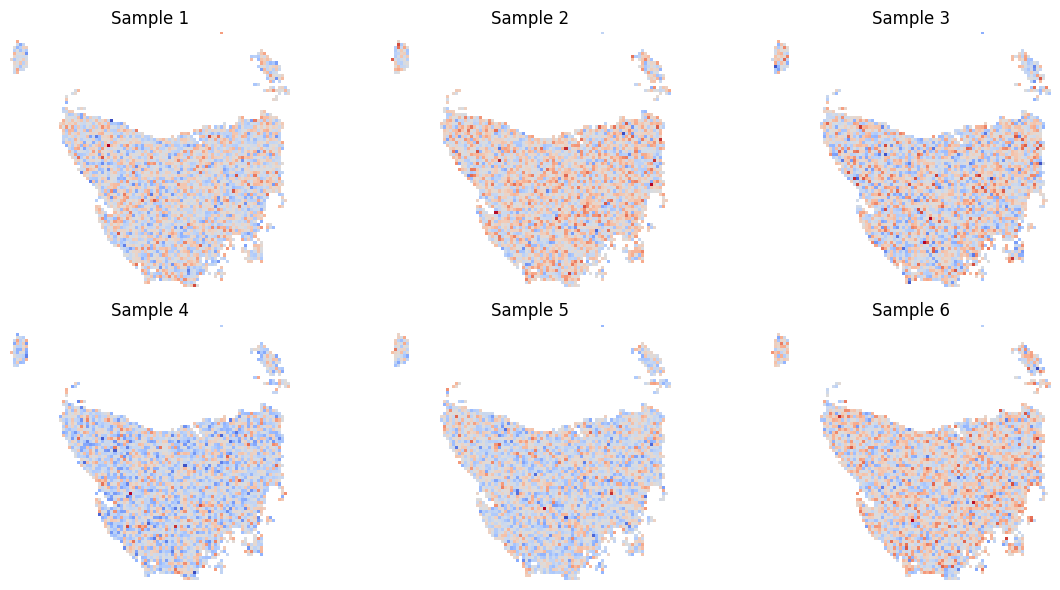

In [66]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i], origin="lower", cmap="coolwarm",
               extent=[lon_grid.min(), lon_grid.max(),
                       lat_grid.min(), lat_grid.max()])
    plt.title(f"Sample {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Testing

In [68]:
import xarray as xr
import pandas as pd

ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\tasmania_clean_node.nc")
time_array = pd.to_datetime(ds["time"].values)   # shape (396,)


In [69]:
def get_prediction_date(sample_index, L=6, lead=1):
    pred_time_index = sample_index + L + lead - 1
    return time_array[pred_time_index]


In [70]:
print(get_prediction_date(0))


1991-07-01 00:00:00


In [71]:
print(get_prediction_date(388))


2023-11-01 00:00:00


In [72]:
all_pred_dates = [get_prediction_date(i) for i in range(len(X_seq))]


In [73]:
print(all_pred_dates[:10])  # first 10 prediction dates
print(all_pred_dates[-10:]) # last 10 prediction dates


[Timestamp('1991-07-01 00:00:00'), Timestamp('1991-08-01 00:00:00'), Timestamp('1991-09-01 00:00:00'), Timestamp('1991-10-01 00:00:00'), Timestamp('1991-11-01 00:00:00'), Timestamp('1991-12-01 00:00:00'), Timestamp('1992-01-01 00:00:00'), Timestamp('1992-02-01 00:00:00'), Timestamp('1992-03-01 00:00:00'), Timestamp('1992-04-01 00:00:00')]
[Timestamp('2023-02-01 00:00:00'), Timestamp('2023-03-01 00:00:00'), Timestamp('2023-04-01 00:00:00'), Timestamp('2023-05-01 00:00:00'), Timestamp('2023-06-01 00:00:00'), Timestamp('2023-07-01 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-09-01 00:00:00'), Timestamp('2023-10-01 00:00:00'), Timestamp('2023-11-01 00:00:00')]


In [77]:
# Ground-truth SPEI for the predicted month
y_true = Y_val[-1]                 # shape (N,)
y_true = np.array(y_true)          # convert to numpy


In [79]:
rmse = np.sqrt(np.mean((mean_pred - y_true)**2))
print("RMSE:", rmse)


RMSE: 0.7648317647339378


In [80]:
full_true = to_full_map(y_true)


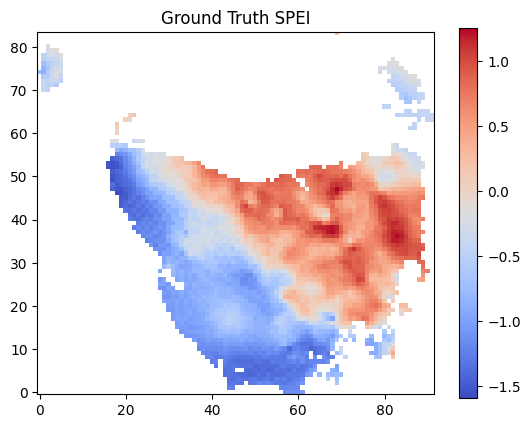

In [81]:
plt.imshow(full_true, origin="lower", cmap="coolwarm")
plt.title("Ground Truth SPEI")
plt.colorbar()
plt.show()


In [82]:
# Ground-truth SPEI for the same sample
y_true = Y_val[-1]           # shape (N,)
y_true = np.array(y_true)    # convert to numpy


In [83]:
mask = ds["valid_mask_flat"].values
lat_grid = ds["lat_grid"].values
lon_grid = ds["lon_grid"].values
H, W = lat_grid.shape

def to_full_map(node_values):
    full = np.full(mask.shape, np.nan)
    full[mask] = node_values
    return full.reshape(H, W)


In [84]:
full_pred = to_full_map(mean_pred)    # predicted SPEI map
full_true = to_full_map(y_true)       # actual SPEI map


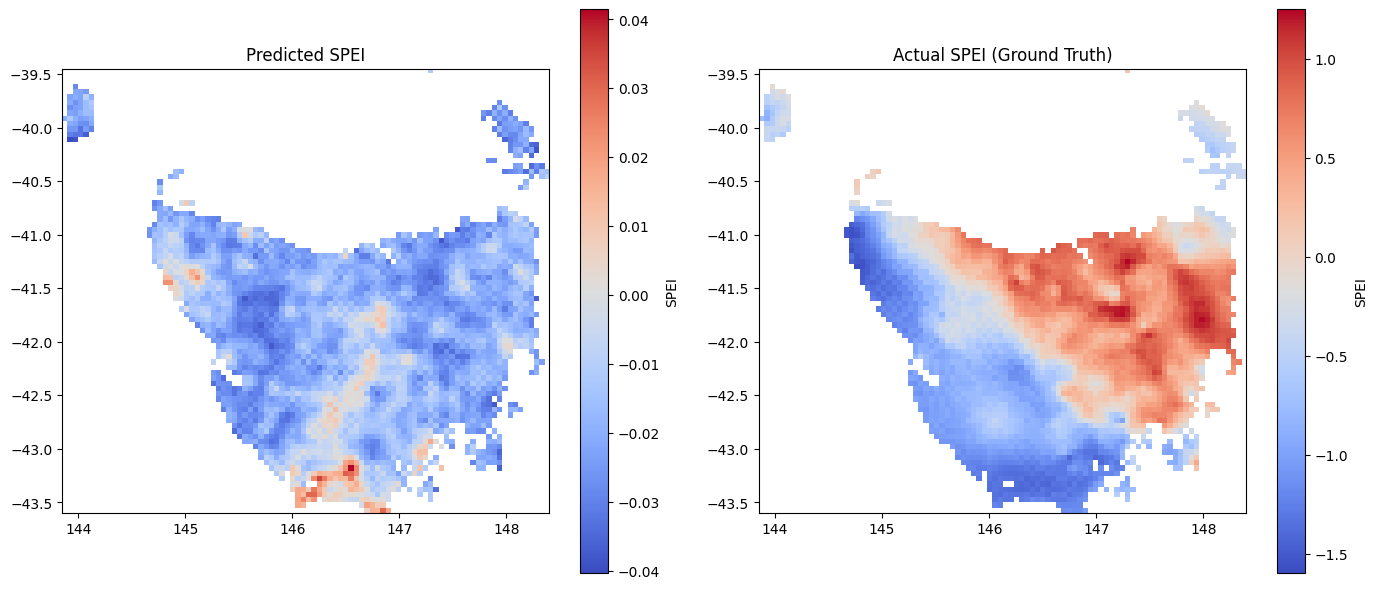

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# --- Predicted map ---
plt.subplot(1,2,1)
plt.imshow(full_pred, origin="lower", cmap="coolwarm",
           extent=[lon_grid.min(), lon_grid.max(),
                   lat_grid.min(), lat_grid.max()])
plt.title("Predicted SPEI")
plt.colorbar(label="SPEI")

# --- Actual map ---
plt.subplot(1,2,2)
plt.imshow(full_true, origin="lower", cmap="coolwarm",
           extent=[lon_grid.min(), lon_grid.max(),
                   lat_grid.min(), lat_grid.max()])
plt.title("Actual SPEI (Ground Truth)")
plt.colorbar(label="SPEI")

plt.tight_layout()
plt.show()
